# Callback 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn.metrics
import datetime
from tensorflow.keras.utils import plot_model


In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.3.0
Eager execution: True


## Loading the Data

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df.head()

,f1,f2,label
0,0.450564,1.074305,0.0
1,0.085632,0.967682,0.0
2,0.117326,0.971521,1.0
3,0.982179,-0.380408,0.0
4,-0.720352,0.955850,0.0


In [5]:
df.shape

(20000, 3)

In [6]:
X = df.drop(columns=['label'])
y = df[['label']]

In [7]:
X.shape

(20000, 2)

In [8]:
y.shape

(20000, 1)

Converting data into train test split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16000, 2)
(4000, 2)
(16000, 1)
(4000, 1)


## Custom Callback Implimentation

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, test_x,test_y):
        super().__init__()
        self.test_x = test_x
        self.test_y = test_y
        
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': [],'f1_score' :[],'AUC' :[]}
        
    def on_epoch_end(self, batch, logs=None):

        y_pred = self.model.predict(self.test_x)
        y_true = self.test_y

        logs["F1 Score"] = sklearn.metrics.f1_score(y_true, y_pred.round(),average='micro')
        logs["AUC"] = sklearn.metrics.roc_auc_score(y_true, y_pred)
        
        self.history['loss'].append(logs.get('loss'))
        self.history['acc'].append(logs.get('acc'))
        self.history['f1_score'].append(logs.get('F1 Score'))
        self.history['AUC'].append(logs.get('AUC'))
        
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_acc', -1) != -1:
            self.history['val_acc'].append(logs.get('val_acc'))
            self.history['val_acc'].append(logs.get('val_acc'))
            
        print("Epoc:{}\t  Loss:{:.4f}\t  acc: {:.4f}\t val_loss: {:.4f}\t val_acc: {:.4f}\t f1 Score: {:.4f}\t AUC:{:.4f}\t".format(len(self.history['loss']),logs.get('loss'),logs.get('acc'),logs.get('val_loss'),logs.get('val_acc'),logs["F1 Score"],logs["AUC"]))
        
        epoch=len(self.history['loss'])
        #print(self.history['val_acc'][epoch])
        
        if((epoch >=3) and (self.history['val_acc'][epoch]<=self.history['val_acc'][epoch-1] and self.history['val_acc'][epoch-1]<=self.history['val_acc'][epoch-2])):
            print("\nValidation Accuracy did not changed in last two epoch, so cancelling training!")
            self.model.stop_training = True
            
        loss = logs.get('loss')
        if np.isnan(loss) or np.isinf(loss):
            print('Invalid loss, terminating training')
            self.model.stop_training = True
            
        for layer in (self.model.layers):
            temp = layer.get_weights()[0]
            if np.isnan(temp).any() or np.isinf(temp).any():
                print("Invalid Weights, terminating training")
                self.model.stop_training = True

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="model_save/weights-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc',  verbose=1, save_best_only=True, mode='auto')

In [13]:
def changeLearningRate(epoch,lr):
    initial_learningrate=lr
    if epoch > 1 and history_own.history['val_acc'][epoch] < history_own.history['val_acc'][epoch-1]:
        changed = initial_learningrate-(initial_learningrate*0.1)
        initial_learningrate=changed
    if(epoch%3==0 and epoch > 1):
        changed = initial_learningrate-(initial_learningrate*0.05)
        initial_learningrate=changed
      
    return initial_learningrate

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

In [15]:
!Rmdir /s /q logs

In [16]:
%load_ext tensorboard

In [17]:
#%reload_ext tensorboard

In [18]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

## Model 1


1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 


In [19]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.7)
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

In [20]:
from tensorflow.keras import layers
model_1 = tf.keras.Sequential([
                            layers.InputLayer(input_shape=(X.shape[1]),name = "InputLayer"),
                            layers.Dense(5, activation='tanh',kernel_initializer=initializer, name="Dense_1"),
                            layers.Dense(5, activation='tanh',kernel_initializer=initializer, name="Dense_2"),
                            layers.Dense(5, activation='tanh',kernel_initializer=initializer, name="Dense_3"),
                            layers.Dense(5, activation='tanh',kernel_initializer=initializer, name="Dense_4"),
                            layers.Dense(5, activation='tanh',kernel_initializer=initializer, name="Dense_5"),
                            layers.Dense(1,name="OutputLayer") ])

In [21]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
Dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
Dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
Dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
Dense_5 (Dense)              (None, 5)                 30        
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
__________________________________________________________

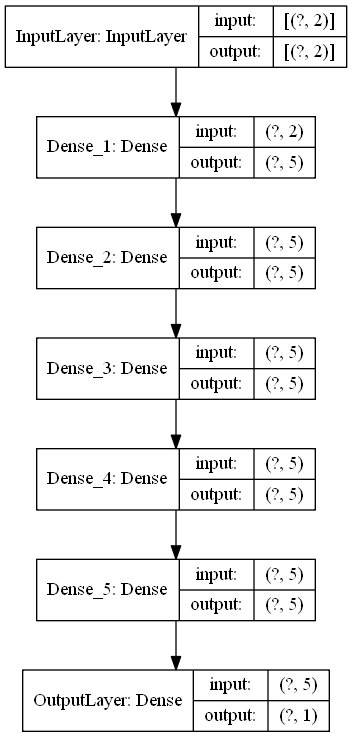

In [22]:
# summarize the model
plot_model(model_1, 'model.png',show_shapes=True)


In [23]:
history_own=LossHistory(X_test,y_test) 

In [24]:
callbacklist=[history_own,checkpoint,lrschedule,tensorboard_callback]

In [25]:
model_1.compile (loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=opt,metrics=['acc'])
history = model_1.fit(X_train, y_train,validation_data=(X_test, y_test),steps_per_epoch=50, batch_size=16,epochs = 10 ,verbose=1,callbacks=callbacklist)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/10
 1/50 [..............................] - ETA: 0s - loss: 0.7697 - acc: 0.5000WARNING:tensorflow:From C:\Users\Manali\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 2/50 [>.............................] - ETA: 46s - loss: 0.8305 - acc: 0.4062WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0443s vs `on_train_batch_end` time: 1.8685s). Check your callbacks.
Epoc:1	  Loss:0.7121	  acc: 0.4925	 val_loss: 0.6941	 val_acc: 0.4955	 f1 Score: 0.4955	 AUC:0.4970	

Epoch 00001: val_acc improved from -inf to 0.49550, saving model to model_save\weights-01-0.4955.hdf5
50/50 [==============================] - 3s 61ms/step - loss: 0.7121 - acc: 0.4925 - val_

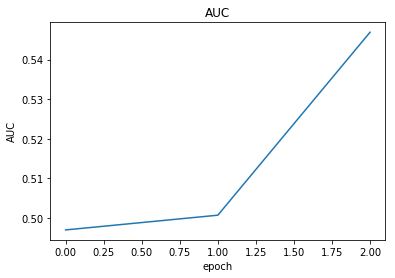

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['AUC'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#%tensorboard --logdir logs/

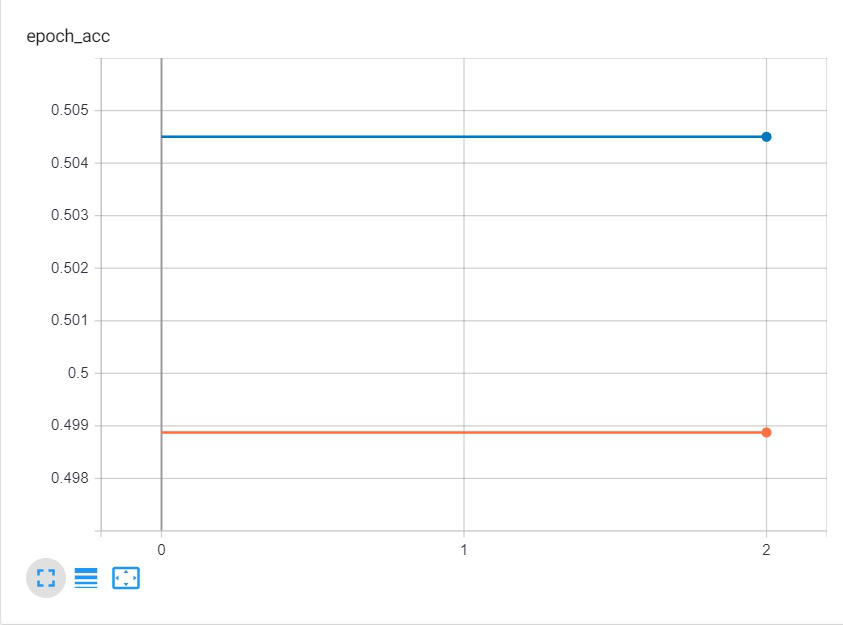

In [80]:
from PIL import Image
Image.open("model_1_acc.jpg") 

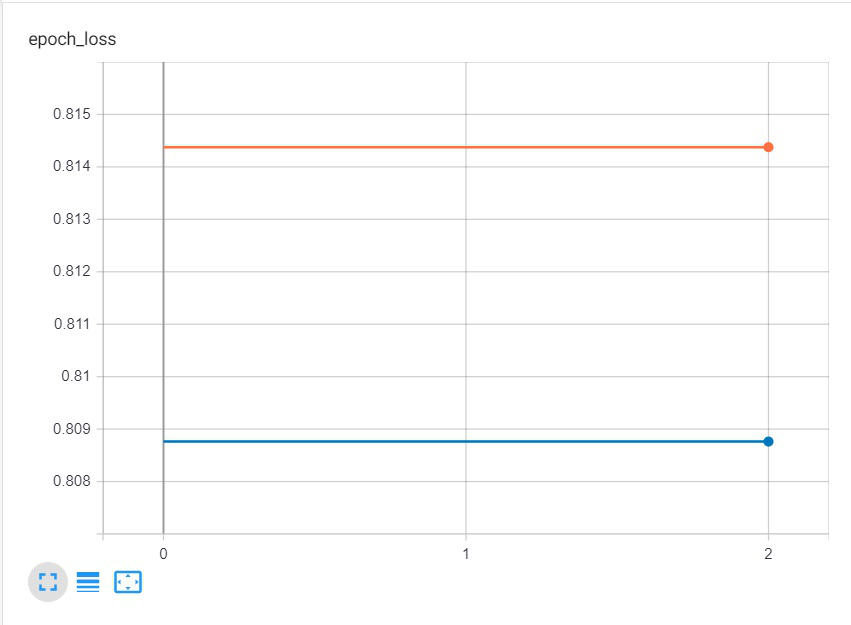

In [81]:
Image.open("model_1_loss.jpg") 

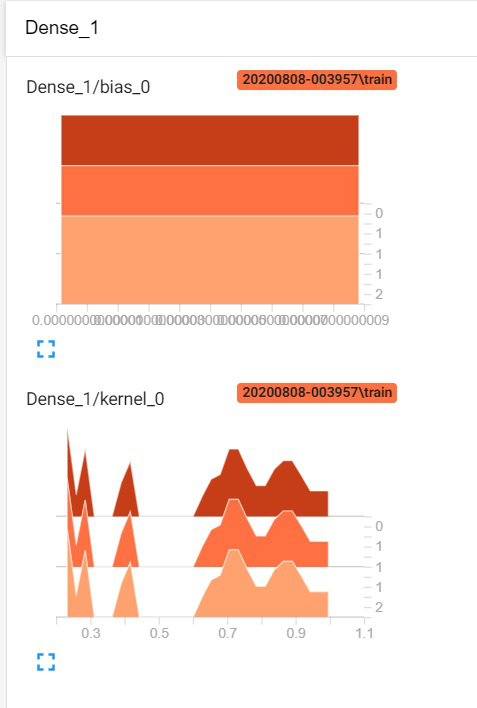

In [82]:
Image.open("model_1_dense1.jpg") 

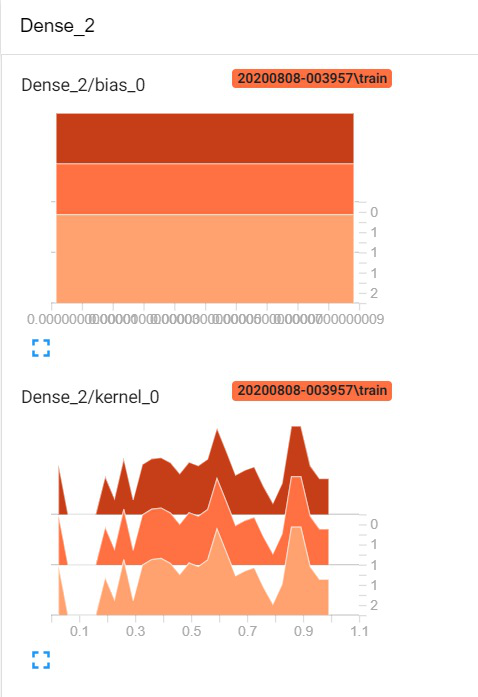

In [83]:
Image.open("model_1_dense2.jpg") 

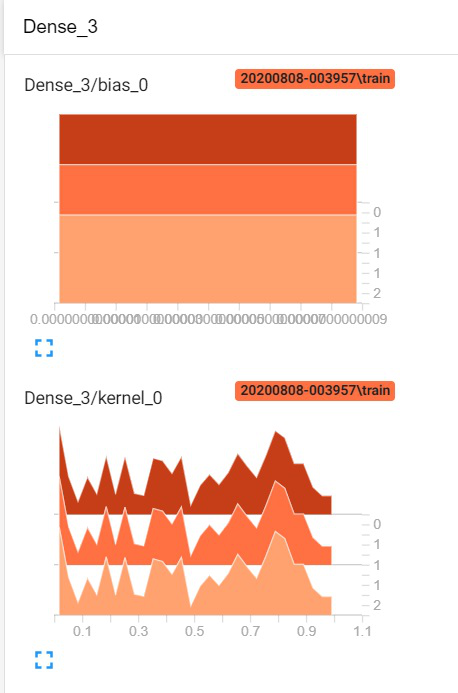

In [84]:
Image.open("model_1_dense3.jpg") 

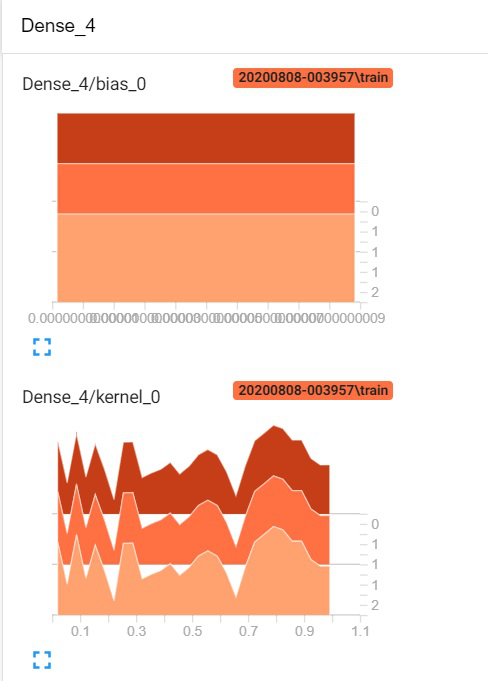

In [85]:
Image.open("model_1_dense4.jpg") 

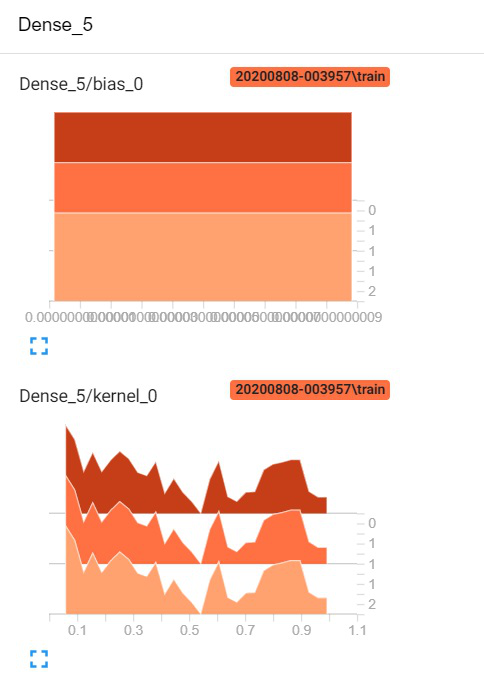

In [86]:
Image.open("model_1_dense5.jpg") 

Observation :
    1.for model 1 epochs vs acc and epochs vs loss scalar graph is constant.
    2.In histogram on each layer it looks like model has learned somehing on each layer. All the layers are gathered around much for
    weight between 01. to 0.3 and  0.7 to 0.9

## Model 2

In [33]:
!Rmdir /s /q logs

In [34]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [36]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

In [37]:
model_2 = tf.keras.Sequential([
                            layers.InputLayer(input_shape=(X.shape[1]),name = "InputLayer"),
                            layers.Dense(5, activation='relu',kernel_initializer=initializer, name="Dense_1"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_2"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_3"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_4"),
                            layers.Dense(5, activation='relu',kernel_initializer=initializer, name="Dense_5"),
                            layers.Dense(1,activation='softmax',name="OutputLayer") ])

In [38]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
Dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
Dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
Dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
Dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 6         
Total params: 356
Trainable params: 356
Non-trainable params: 0
________________________________________________________

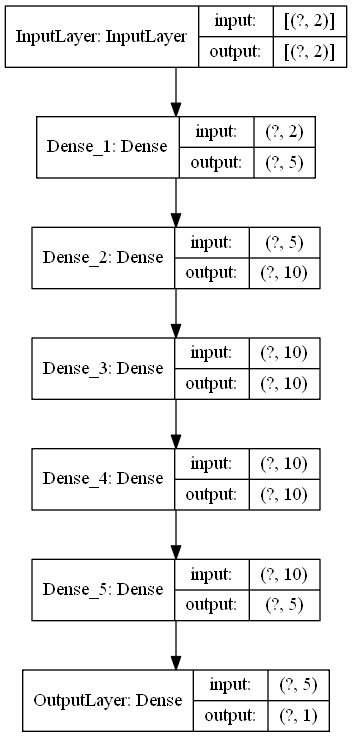

In [39]:
plot_model(model_2, 'model_2.png',show_shapes=True)

In [40]:
history_own=LossHistory(X_test,y_test) 
callbacklist=[history_own,checkpoint,lrschedule,tensorboard_callback]

In [44]:
model_2.compile (loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=opt,metrics=['acc'])
hist = model_2.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=16,epochs = 10 ,verbose=1, callbacks=callbacklist)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/10
 951/1000 [===========================>..] - ETA: 0s - loss: 0.8142 - acc: 0.4991Epoc:1	  Loss:0.8144	  acc: 0.4989	 val_loss: 0.8088	 val_acc: 0.5045	 f1 Score: 0.5045	 AUC:0.5000	

Epoch 00001: val_acc did not improve from 0.50450
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8144 - acc: 0.4989 - val_loss: 0.8088 - val_acc: 0.5045

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/10
 940/1000 [===========================>..] - ETA: 0s - loss: 0.8129 - acc: 0.5003Epoc:2	  Loss:0.8144	  acc: 0.4989	 val_loss: 0.8088	 val_acc: 0.5045	 f1 Score: 0.5045	 AUC:0.5000	

Epoch 00002: val_acc did not improve from 0.50450
1000/1000 [==============================] - 2s 2ms/step - loss: 0.8144 - acc: 0.4989 - val_loss: 0.8088 - val_acc: 0.5045

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/10
 965/1

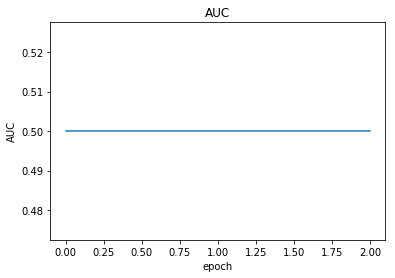

In [46]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(hist.history['AUC'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [88]:
# %tensorboard --logdir logs

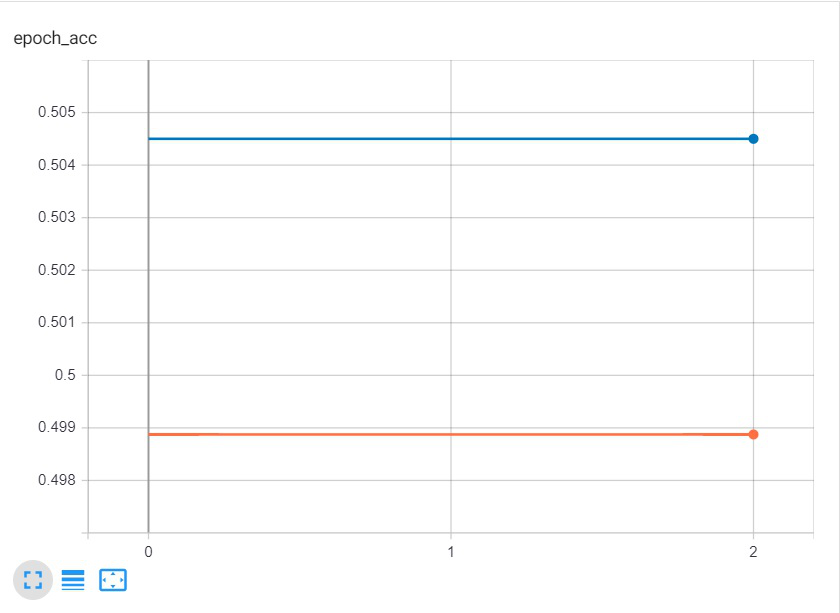

In [47]:
from PIL import Image
Image.open("model2-epoch-acc.jpg") 
    

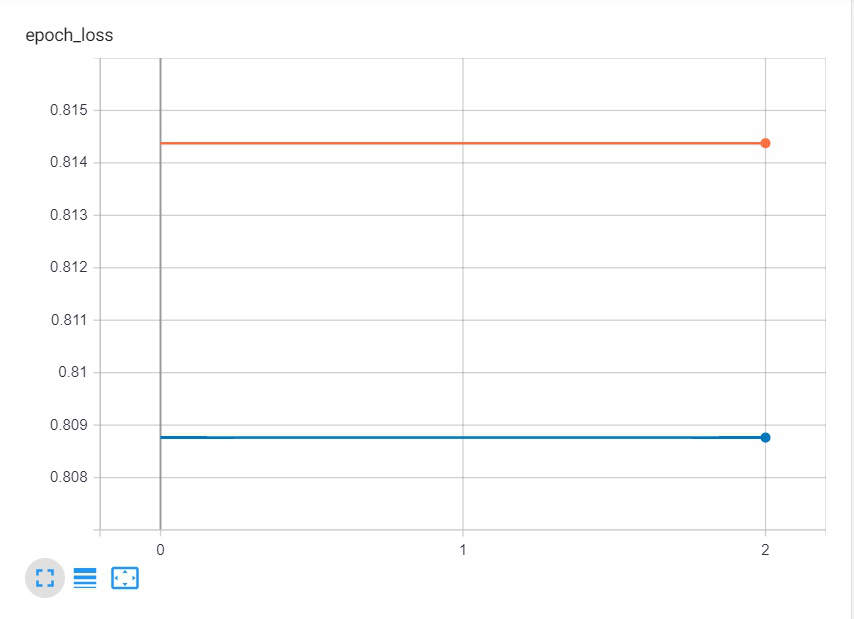

In [48]:
Image.open("model2-epoch-loss.jpg") 

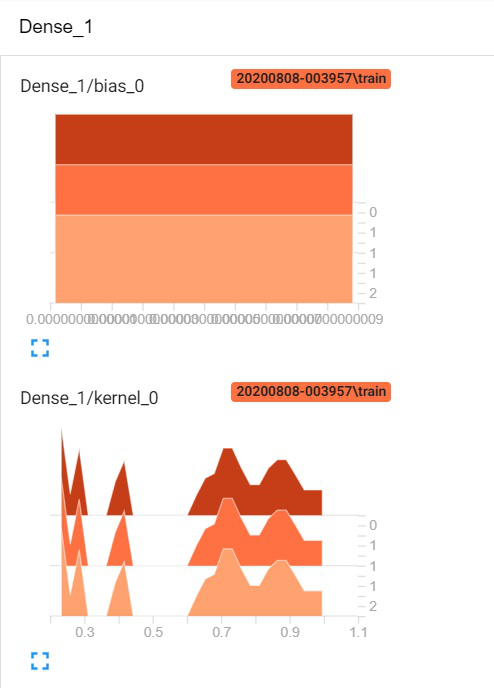

In [49]:
Image.open("model2-dense1.jpg") 

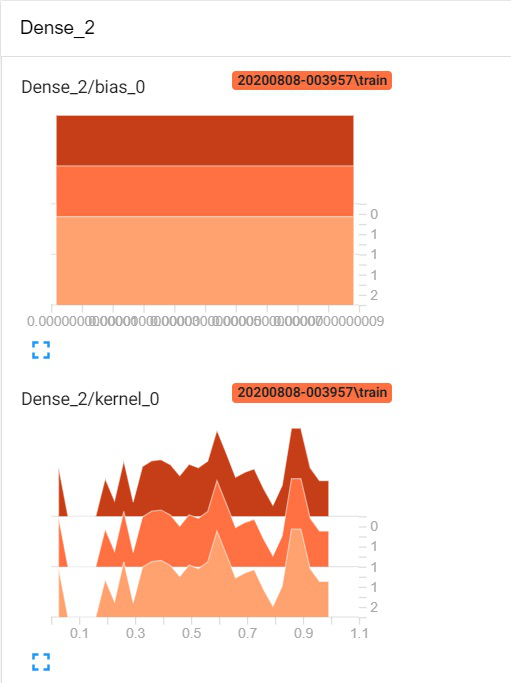

In [50]:
Image.open("model2-dense2.jpg") 

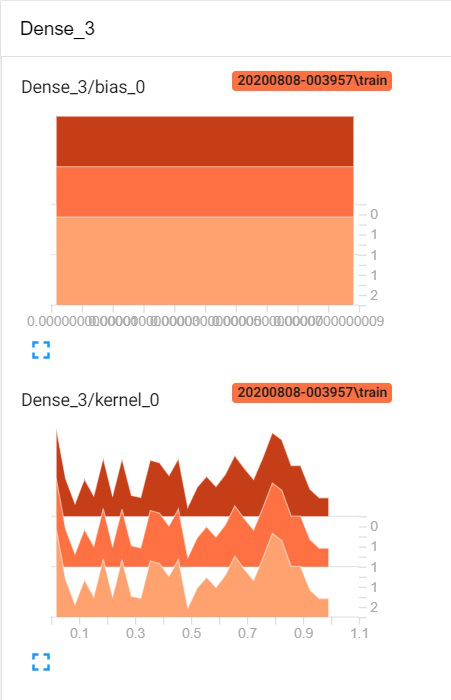

In [51]:
Image.open("model2-dense3.jpg") 

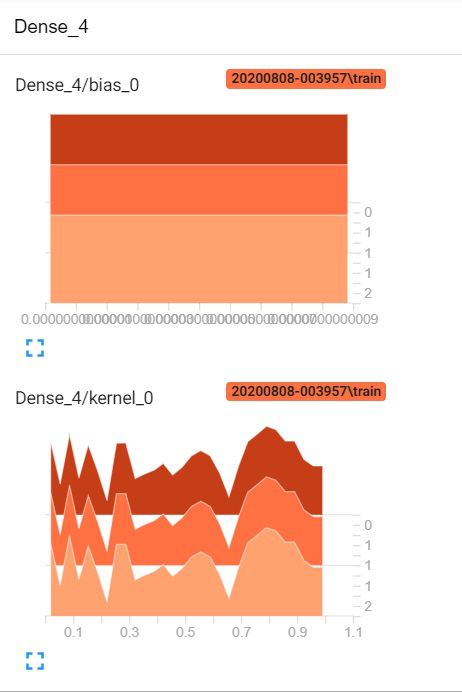

In [52]:
Image.open("model2-dense4.jpg") 

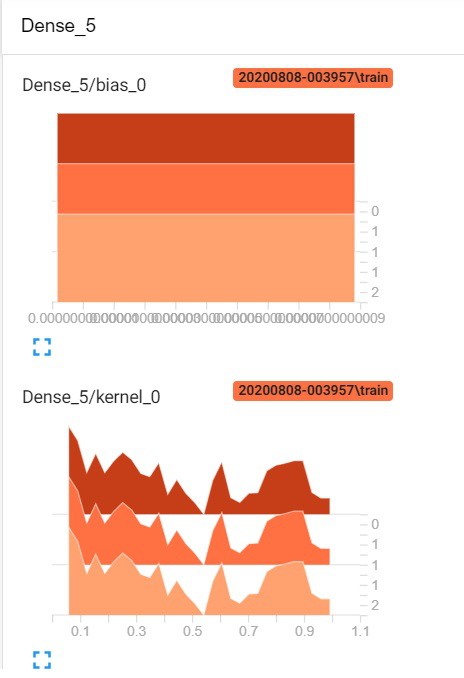

In [53]:
Image.open("model2-dense5.jpg") 

Observation :
     1.for model 2 epochs vs acc and epochs vs loss scalar graph is constant accuracy is not increase and loss not decrease for        model 2. 
     2.In histogram on each layer it looks like model has varies for all the weight range between 0.3 to 0.9 .


## Model 3

In [54]:
!Rmdir /s /q logs

logs\202008~1\train - The directory is not empty.
logs\202008~1\VALIDA~1 - The directory is not empty.


In [55]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [56]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [57]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
initializer = tf.keras.initializers.HeUniform()

In [58]:
model_3 = tf.keras.Sequential([
                            layers.InputLayer(input_shape=(X.shape[1]),name = "InputLayer"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_1"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_2"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_3"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_4"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_5"),
                            layers.Dense(1,activation='softmax',name="OutputLayer") ])

In [59]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
Dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
Dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
Dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
Dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 11        
Total params: 481
Trainable params: 481
Non-trainable params: 0
________________________________________________________

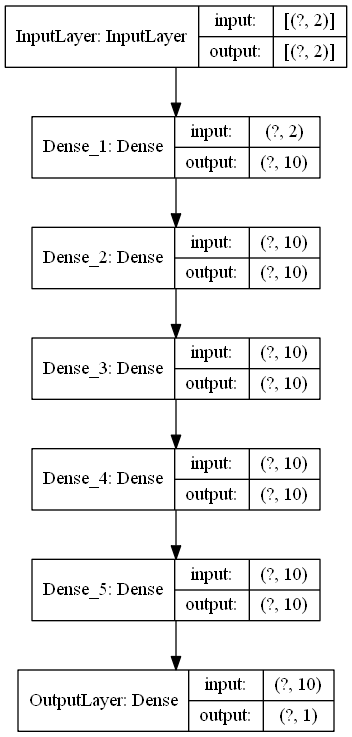

In [60]:
plot_model(model_3, 'model_3.png',show_shapes=True)

In [61]:
history_own=LossHistory(X_test,y_test) 
callbacklist=[history_own,checkpoint,lrschedule,tensorboard_callback]

In [64]:
model_3.compile (loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=opt,metrics=['acc'])
his = model_3.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=16,epochs = 10 ,verbose=1, callbacks=callbacklist)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/10
 940/1000 [===========================>..] - ETA: 0s - loss: 0.8141 - acc: 0.4991Epoc:1	  Loss:0.8144	  acc: 0.4989	 val_loss: 0.8088	 val_acc: 0.5045	 f1 Score: 0.5045	 AUC:0.5000	

Epoch 00001: val_acc did not improve from 0.50450
1000/1000 [==============================] - 6s 6ms/step - loss: 0.8144 - acc: 0.4989 - val_loss: 0.8088 - val_acc: 0.5045

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/10
 995/1000 [============================>.] - ETA: 0s - loss: 0.8144 - acc: 0.4989Epoc:2	  Loss:0.8144	  acc: 0.4989	 val_loss: 0.8088	 val_acc: 0.5045	 f1 Score: 0.5045	 AUC:0.5000	

Epoch 00002: val_acc did not improve from 0.50450
1000/1000 [==============================] - 1s 1ms/step - loss: 0.8144 - acc: 0.4989 - val_loss: 0.8088 - val_acc: 0.5045

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/10
 952/1

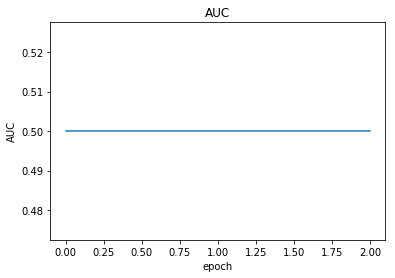

In [65]:
plt.figure()
plt.plot(his.history['AUC'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [98]:
#%tensorboard --logdir logs

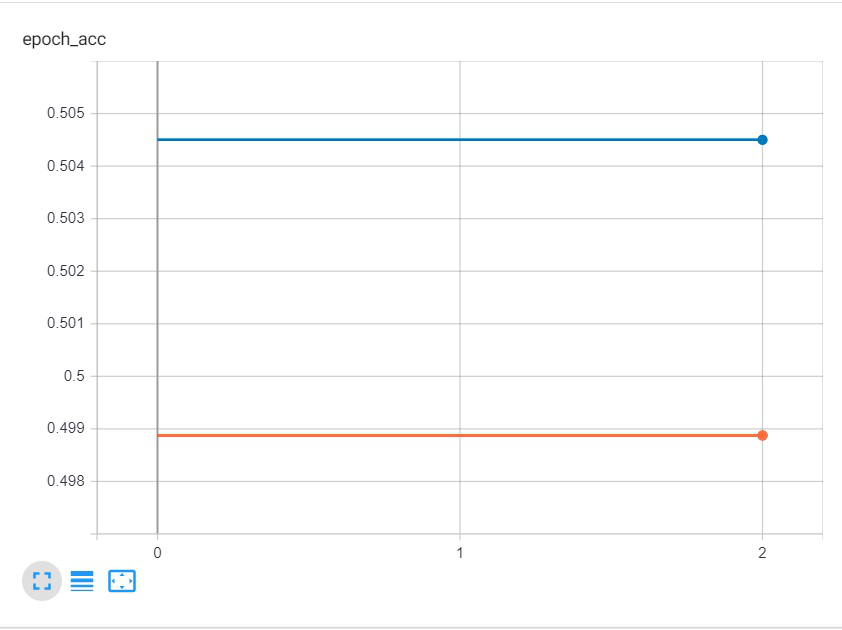

In [89]:
from PIL import Image
Image.open("model_3_acc.jpg")     

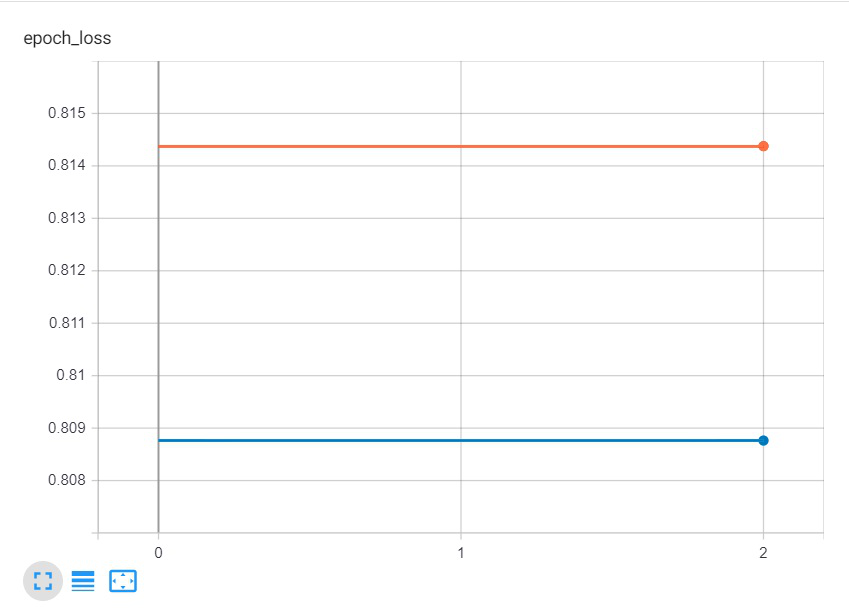

In [90]:
Image.open("model_3_loss.jpg")    

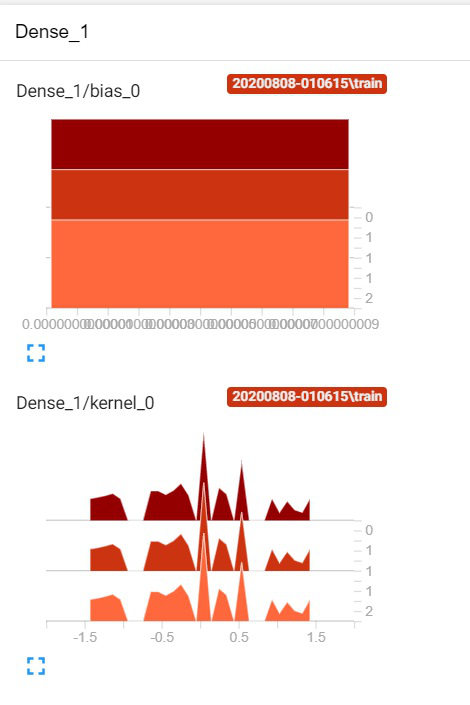

In [92]:
Image.open("model_3_dense1.jpg") 

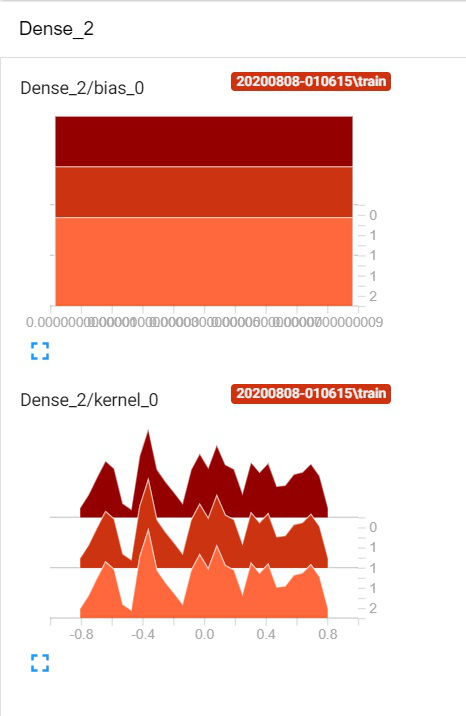

In [93]:
Image.open("model_3_dense2.jpg") 

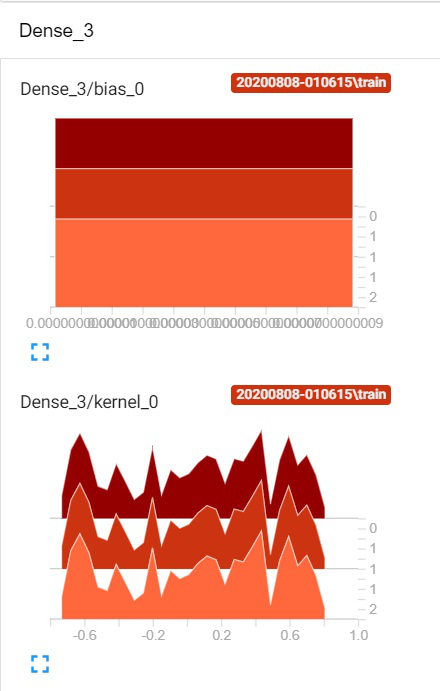

In [94]:
Image.open("model_3_dense3.jpg") 

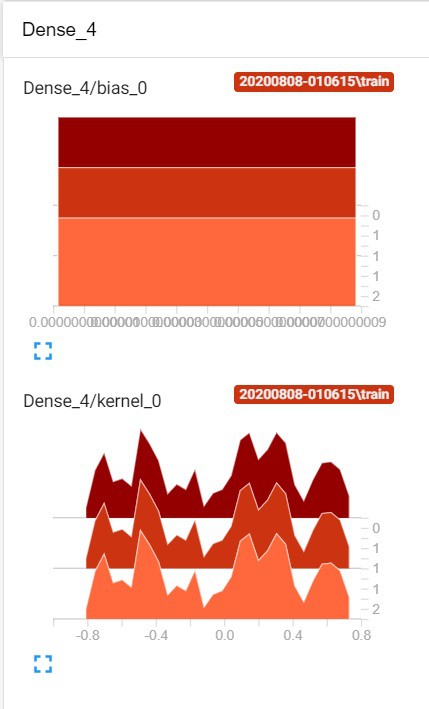

In [95]:
Image.open("model_3_dense4.jpg") 

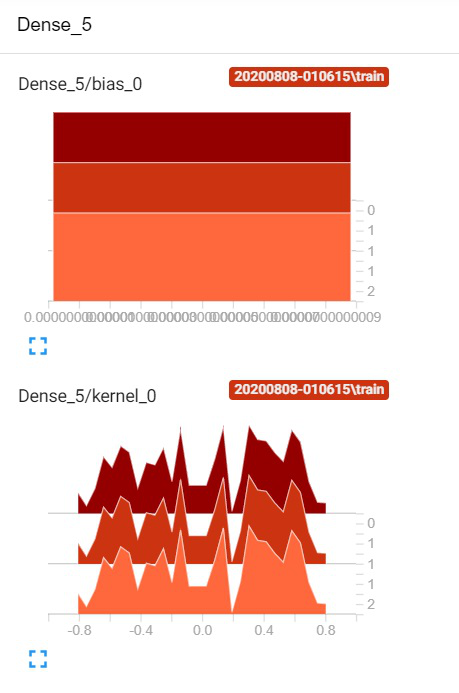

In [97]:
Image.open("model_3_dense5.jpg") 

Observation :
    In models 3 histogram, the histogram are varying between -0.4 to 0.4. Highest weight variaion is happening between thsese weight

## Model 4

1. used sigmoid as an activation for first theree layer
2. Used relu as an activation for last two layer except output layer.
3. used SGD with momentum as optimizer.
4. used he_uniform() as initilizer.
5. Analyzed your output and training process

In [69]:
!Rmdir /s /q logs

logs\202008~1\train\events.out.tfevents.1596828572.MANALI-PC.7468.13682.v2 - Access is denied.
logs\202008~1\VALIDA~1\events.out.tfevents.1596828575.MANALI-PC.7468.16252.v2 - Access is denied.
logs\202008~2\train - The directory is not empty.
logs\202008~2\VALIDA~1 - The directory is not empty.


In [70]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [71]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [72]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
initializer = tf.keras.initializers.HeUniform()

In [73]:
model_4 = tf.keras.Sequential([
                            layers.InputLayer(input_shape=(X.shape[1]),name = "InputLayer"),
                            layers.Dense(10, activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30), name="Dense_1"),
                            layers.Dense(15, activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=10), name="Dense_2"),
                            layers.Dense(25, activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=5), name="Dense_3"),
                            layers.Dense(15, activation='relu',kernel_initializer=initializer, name="Dense_4"),
                            layers.Dense(10, activation='relu',kernel_initializer=initializer, name="Dense_5"),
                            layers.Dense(1,activation='softmax',name="OutputLayer") ])

In [74]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
Dense_2 (Dense)              (None, 15)                165       
_________________________________________________________________
Dense_3 (Dense)              (None, 25)                400       
_________________________________________________________________
Dense_4 (Dense)              (None, 15)                390       
_________________________________________________________________
Dense_5 (Dense)              (None, 10)                160       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 11        
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
____________________________________________________

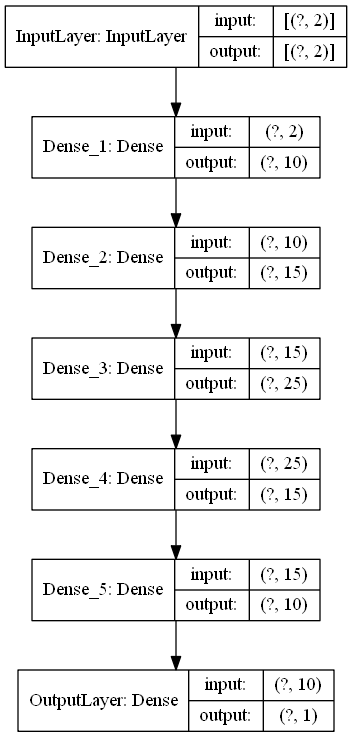

In [75]:
plot_model(model_4, 'model.png',show_shapes=True)

In [76]:
history_own=LossHistory(X_test,y_test) 
callbacklist=[history_own,checkpoint,lrschedule,tensorboard_callback]

In [99]:
model_4.compile (loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=opt,metrics=['acc'])
hist4 = model_4.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32,epochs = 50,steps_per_epoch=50,verbose=1, callbacks=callbacklist)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/50
 3/50 [>.............................] - ETA: 19s - loss: 0.8445 - acc: 0.4688Epoc:1	  Loss:0.8051	  acc: 0.5081	 val_loss: 0.8088	 val_acc: 0.5045	 f1 Score: 0.5045	 AUC:0.5000	

Epoch 00001: val_acc did not improve from 0.50450
50/50 [==============================] - 2s 36ms/step - loss: 0.8051 - acc: 0.5081 - val_loss: 0.8088 - val_acc: 0.5045

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/50
43/50 [========================>.....] - ETA: 0s - loss: 0.8045 - acc: 0.5087Epoc:2	  Loss:0.8120	  acc: 0.5013	 val_loss: 0.8088	 val_acc: 0.5045	 f1 Score: 0.5045	 AUC:0.5000	

Epoch 00002: val_acc did not improve from 0.50450
50/50 [==============================] - 0s 5ms/step - loss: 0.8120 - acc: 0.5013 - val_loss: 0.8088 - val_acc: 0.5045

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/50
48/50 [=============

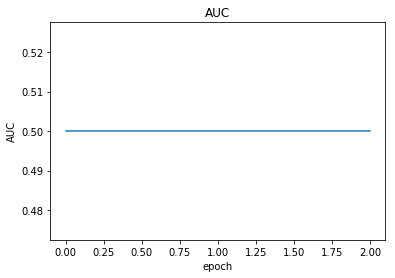

In [100]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(hist4.history['AUC'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [108]:
# %tensorboard --logdir logs

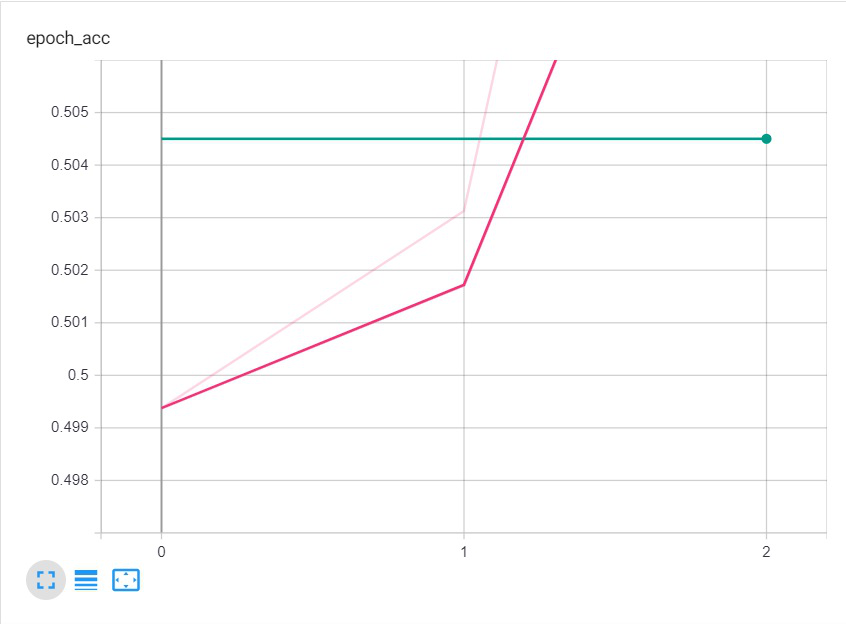

In [101]:
Image.open("model_4_acc.jpg") 

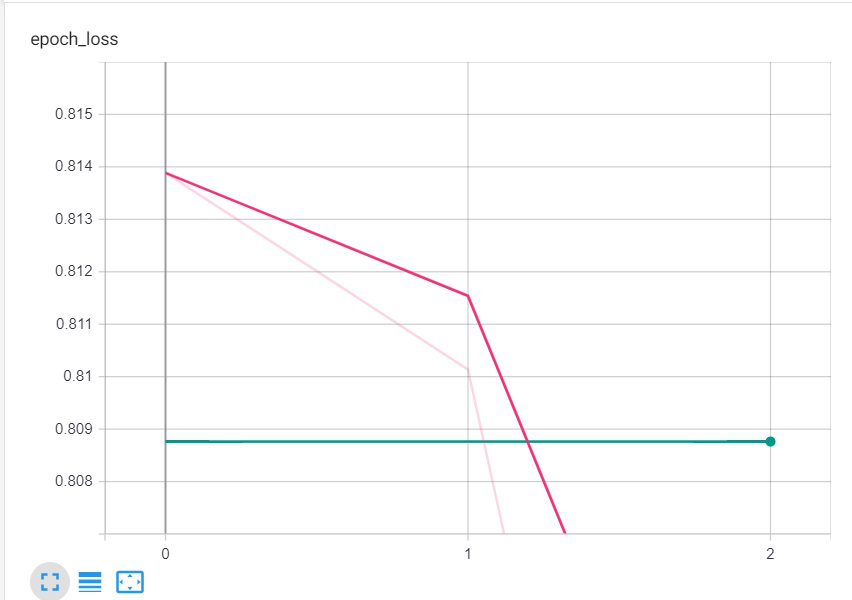

In [102]:
Image.open("model_4_loss.jpg") 

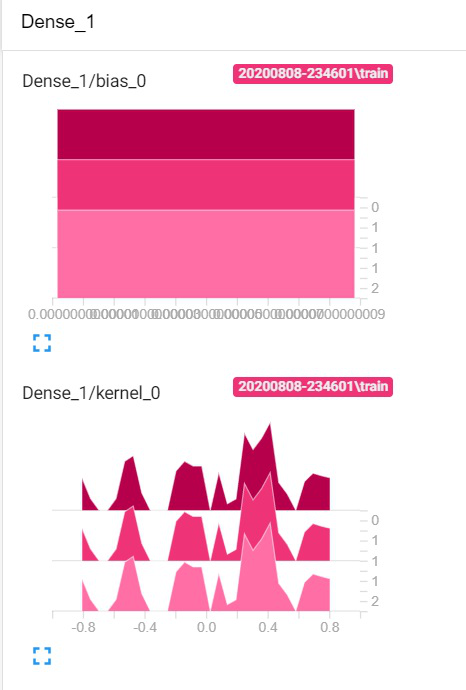

In [103]:
Image.open("model_4_dense1.jpg") 

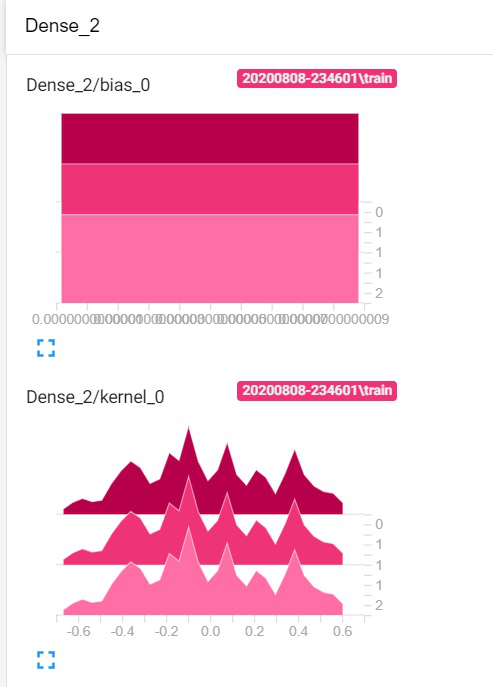

In [104]:
Image.open("model_4_dense2.jpg") 

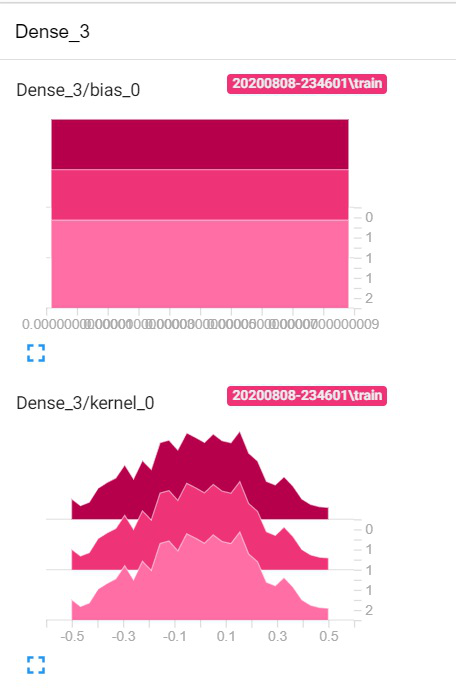

In [105]:
Image.open("model_4_dense3.jpg") 

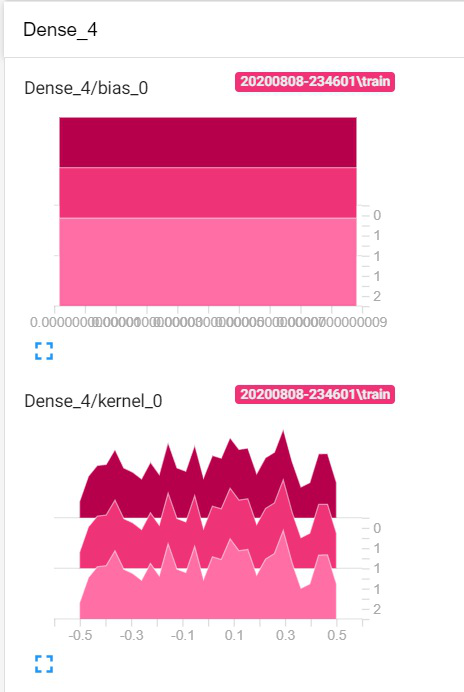

In [106]:
Image.open("model_4_dense4.jpg") 

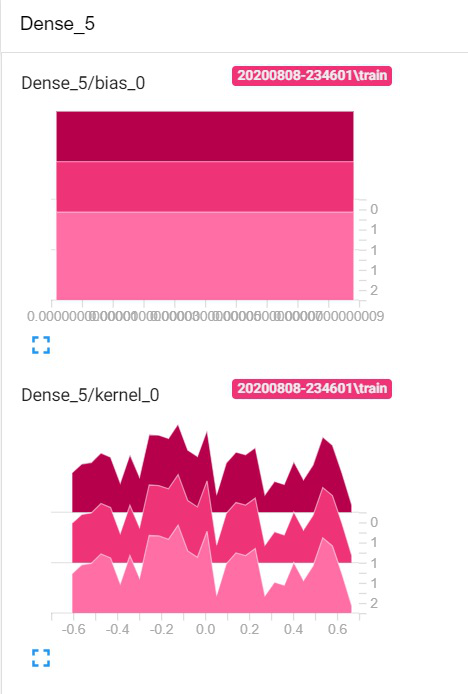

In [107]:
Image.open("model_4_dense5.jpg") 

Observation :
    
1. In model 4 the scalar grpah for epoch vs loss and epoch vs acc are very different form rest of the models. and validation loss and acc 
is changing comparitevaly train loss and acc.

2. In hitogram, the weights are varying for every layer. for layer 1 0.2 to 0.4 is the highest weight , for layer 2 -0.2 to 0.2 ,
for layer 3 , -.3 to 0.3 , for layer 4 , -0.5 to 0.5 and for last layer 5, -0.6 o 0.6 are the distributions of the weight.

In [ ]:
# del /q %TMP%\.tensorboard-info\*